In [2]:
import pandas as pd
pd.options.plotting.backend = "plotly"

import plotly.io as pio
pio.renderers.default = 'iframe'  # Set static image rendering

import json
import pandas as pd
import datetime
import numpy as np
from sklearn.metrics import mean_absolute_error

In [3]:
!pip3 install simpy --break-system-packages

Defaulting to user installation because normal site-packages is not writeable


In [4]:
class DataLoader:
    def __init__(self, file: str):
        """
        Initializes a DataLoader object.

        Parameters:
        - data_file (str): The path to the data file.

        """
        self.file = file

    def load_json_data(self) -> list:
        """
        Loads JSON data from the file and returns a list of dictionaries.

        Returns:
        - data (list): A list of dictionaries representing the JSON data.

        """
        with open(self.file, 'r') as f:
            data = json.load(f)
        return data

    def create_dataframe(self) -> pd.DataFrame:
        """
        Converts the loaded JSON data into a Pandas DataFrame.

        Returns:
        - df (pandas.DataFrame): The converted DataFrame.

        """
        data = self.load_json_data()

        # Convert the data to a DataFrame
        df = pd.DataFrame(data)

        # Convert the timestamp to a datetime object
        df['date'] = pd.to_datetime(df['timestamp'])

        # Drop the timestamp column
        df.drop(columns="timestamp", inplace=True)

        return df


    def preprocess(self) -> pd.DataFrame:
        df = self.create_dataframe()
        
        # Ensure that the date is in UTC
        df["date"] = df["date"].dt.tz_convert("UTC") 
        
        # Calculate NetPosition before setting the index
        df['NetPosition'] = df['sent'] - df['recieved']
        
        # Create datetime index
        #df = df.set_index('date')
        
        return df

In [5]:
# Data for loading and preprocessing
loader = DataLoader(file='energy_readings.json')
df = loader.preprocess()
df.head()

,ID,recieved,sent,date,NetPosition
0,5432,0.0,186.0,2023-05-15 07:00:00+00:00,186.0
1,5432,0.0,165.8,2023-05-22 05:00:00+00:00,165.8
2,5432,0.0,107.6,2023-06-17 01:00:00+00:00,107.6
3,5432,0.0,75.0,2023-06-26 02:00:00+00:00,75.0
4,5432,0.0,93.4,2023-06-29 00:00:00+00:00,93.4


In [6]:
df.to_csv("exported_data.csv", index=False)

## EDA

Start of with the EDA to create a general overview of data you are working with.

In [7]:
df_new = pd.DataFrame()
start_date = '2023-01-01'
largest_indices = df.nlargest(5, 'recieved').index
print("Indices with largest consumption:", largest_indices)
df_new[df['ID'].isin(largest_indices)]

Indices with largest consumption: Index([1130103, 790841, 790662, 792785, 790734], dtype='int64')


/tmp/ipykernel_44189/1050883936.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



""


In [8]:
from tempfile import template
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Identify IDs where 'received' is never 0 and 'sent' is never 0
random_ids = df['ID'].sample(n=5, random_state=42).tolist()
#ids_with_neither_zero = ids_with_neither_zero[:5]

df_neither_zero = df[df['ID'].isin(random_ids)].reset_index().sort_values(by='date')

# Plot for IDs with neither 'received' nor 'sent' equal to 0
fig_neither_zero = px.line(
    df_neither_zero,
    x='date',
    y='NetPosition',
    color='ID',
    title='Poraba in proizvodnja električne energije skozi čas, pri posameznih odjemalcih',
    labels={'date': 'Datum', 'NetPosition': 'Poraba ali proizvodnja el. energije [kWh]'},
    template='plotly'
)
fig_neither_zero.show()

In [9]:
df_210115 = df[df['ID']=='210115'].reset_index().sort_values(by='date')

# Plot for IDs with neither 'received' nor 'sent' equal to 0
fig_df_210115 = px.line(
    df_210115,
    x='date',
    y='NetPosition',
    title='Poraba in proizvodnja električne energije skozi čas, pri odjemalcu št. 210115',
    labels={'date': 'Datum', 'NetPosition': 'Poraba ali proizvodnja el. energije [kWh]'},
    template='plotly'
)
fig_df_210115.show()

In [10]:
df_210115.reset_index().sort_values(by='date')
df_210115['recieved'] = df_210115['recieved'] * -1
# Melt the DataFrame to combine 'sent' and 'received' into one column
df_210115_melted = df_210115.melt(
    id_vars=['date', 'ID'],  # Columns to keep
    value_vars=['sent', 'recieved'],  # Columns to melt
    var_name='smer',  # New column to differentiate 'sent' and 'received'
    value_name='Value'  # Column for their values
)

# Plot using Plotly Express
fig_df_210115 = px.line(
    df_210115_melted,
    x='date',
    y='Value',
    color='smer',  # Different lines for 'sent' and 'received'
    title='Poraba in proizvodnja električne energije skozi čas, pri odjemalcu št. 210115',
    labels={'date': 'Datum', 'Value': 'Poraba ali proizvodnja el. energije [kWh]'},
    template='plotly'
)

fig_df_210115.show()

In [11]:
user_stats = df_210115['NetPosition'].agg(['mean', 'max']).reset_index()
user_stats.rename(columns={'mean': 'AverageConsumption', 'max': 'MaxConsumption'}, inplace=True)

print(user_stats)

  index  NetPosition
0  mean    -2.546342
1   max    23.580000


In [12]:
# Povprečna in največja poraba za vsakega odjemalca
customer_stats = df.groupby('ID')['NetPosition'].agg(['mean', 'max']).reset_index()

print(customer_stats)

# Stolpični graf za odjemalce
fig = px.bar(
    customer_stats,
    x='ID',
    y=['mean', 'max'],
    title='Povprečna in največja poraba po odjemalcih',
    labels={'value': 'Poraba [kWh]', 'ID': 'Odjemalec'},
    color='ID',
    template='plotly'
)

# Prikaz grafa
fig.show()

                                   ID       mean      max
0                         -Piadeno-XX   1.007030  491.200
1                              000027 -17.196568   11.092
2    00700000907110000000000000675164   0.442204    5.712
3    0070000090740000010190002665882A   0.609336    3.534
4     0070000906110000000000000669150   0.870510    8.155
..                                ...        ...      ...
443                             97319  -0.212372    2.991
444                             97729  -0.606497    6.850
445                             98253  -0.337526    0.009
446                             98404   0.134074    6.742
447                              TEST   0.330398    6.440

[448 rows x 3 columns]


In [13]:
# Sort the DataFrame by date
df_sorted = df.sort_index()
# Plot using Plotly
import plotly.graph_objs as go

# Create traces for each unique ID
traces = []
for id_value in df_sorted['ID'].unique():
    subset = df_sorted[df_sorted['ID'] == id_value]
    trace = go.Scatter(
        x=subset.index, 
        y=subset['NetPosition'], 
        mode='lines', 
        name=str(id_value)
    )
    traces.append(trace)

# Create the layout
layout = go.Layout(
    title='NetPosition Over Time by ID',
    xaxis={'title': 'Date'},
    yaxis={'title': 'Net Position'}
)

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()

In [15]:
# Pretvorba datuma v datetime format
df['date'] = pd.to_datetime(df['date'])

# Izvlečenje dodatnih informacij (mesec, dan v tednu, ura)
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek  # 0 = ponedeljek, 6 = nedelja
df['hour'] = df['date'].dt.hour

monthly_avg = df.groupby('month')['NetPosition'].mean().reset_index()

# Prikaz z Plotly
import plotly.express as px
fig_monthly = px.line(
    monthly_avg,
    x='month',
    y='NetPosition',
    title='Povprečna poraba energije po mesecih',
    labels={'month': 'Mesec', 'NetPosition': 'Povprečna poraba [kWh]'},
    template='plotly'
)
fig_monthly.show()


In [16]:
daily_avg = df.groupby('day_of_week')['NetPosition'].mean().reset_index()

fig_daily = px.bar(
    daily_avg,
    x='day_of_week',
    y='NetPosition',
    title='Povprečna poraba energije po dnevih v tednu',
    color='day_of_week',
    labels={'day_of_week': 'Dan v tednu (0 = Ponedeljek)', 'NetPosition': 'Povprečna poraba [kWh]'},
    template='plotly'
)
fig_daily.show()

In [18]:
user_stats = df.groupby('ID')['NetPosition'].agg(['mean', 'max', 'std']).reset_index()
user_stats.fillna(0, inplace=True)  # Nadomestitev manjkajočih vrednosti z 0

from sklearn.cluster import KMeans
import plotly.express as px

# Pripravite podatke za clustering (npr. povprečje, maksimum in standardni odklon)
X = user_stats[['mean', 'max', 'std']]

# Uporaba K-means algoritma
kmeans = KMeans(n_clusters=5, random_state=42)  # Nastavite število skupin
user_stats['Cluster'] = kmeans.fit_predict(X)

# Prikazovanje rezultatov
fig_clusters = px.scatter(
    user_stats,
    x='mean',
    y='max',
    color='Cluster',  # Barva glede na skupino
    size='std',  # Velikost kroga glede na variabilnost porabe
    title='Skupine odjemalcev na podlagi porabe energije',
    labels={'mean': 'Povprečna poraba [kWh]', 'max': 'Največja poraba [kWh]'},
    color_continuous_scale=px.colors.sequential.Viridis,
    template='plotly'
)
fig_clusters.update_layout(
    width=600,
    height=600)
fig_clusters.show()

In [6]:
!jupyter labextension install jupyterlab-plotly

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
/home/gaspers/.local/lib/python3.10/site-packages/jupyterlab/debuglog.py:54: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
/home/gaspers/.local/lib/python3.10/site-packages/jupyterlab/debuglog.py:55: UserWarning: ValueError: Please install nodejs >=20.0.0 before continuing. nodejs may be installed using conda or directly from the nodejs website.
  warnings.warn(msg[-1].strip())
/home/gaspers/.local/lib/python3.10/site-packages/jupyterlab/debuglog.py:56: UserWarning: See the log file for details: /tmp/jupyterlab-debug-25jo9geg.log
  warnings.warn(f"See the log file for details: {log_path!s}")


# Predictive model

Implement your predictive model here.

# Results

Present your results here.

In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

sent_grouped = df.groupby('sent').mean()
received_grouped = df.groupby('received').mean()
Date_grouped = df.groupby('Date').mean()





In [ ]:
fig_all.show()

In [ ]:
df["ID"][5432]

In [ ]:
df_5432 = df[df['ID'] == "5432"]

In [ ]:
df = df_5432

In [ ]:
fig = go.Figure()

df['date'] = pd.to_datetime(df['date'])

# Add line for 'sent'
fig.add_trace(go.Line(x=df['date'], y=df['sent'], name='Sent'))

# Add line for 'received'
fig.add_trace(go.Line(x=df['date'], y=df['received'], name='Received'))

# Update layout
fig.update_layout(
    title='Sent and Received Over Time',
    xaxis_title='Date',
    yaxis_title='Amount',
    legend_title='Type',
    template='plotly'
)

# Show plot
fig.show()

In [ ]:
df['sent']

In [131]:
df_sorted = df.reset_index().sort_values(by='date')
fig_all = px.line(
    df_sorted,
    x='date',
    y='NetPosition',
    color='ID',
    title='Poraba energije',
    labels={'date': 'Datum', 'NetPosition': 'Poraba energije [kWh]'},
    template='simple_white'
)

In [132]:
fig_all.show()

In [14]:
class Consumer:
    def __init__(self, consumer_id, initial_storage=0):
        self.id = consumer_id
        self.storage = initial_storage  # Battery storage level
        self.history = []  # To track power levels over time

    def update_storage(self, received, sent, timestamp):
        """ Updates the battery storage based on received and sent power """
        self.storage += (received - sent)
        self.history.append((timestamp, self.storage))
    
    def get_status(self):
        return {"ID": self.id, "Storage": self.storage}

In [15]:
# Create a dictionary of Consumer objects
consumers = {}

# Iterate through dataset and update consumers
for _, row in df.iterrows():
    consumer_id = row["ID"]
    received = row["recieved"]
    sent = row["sent"]
    timestamp = row["date"]

    # Create consumer if not exists
    if consumer_id not in consumers:
        consumers[consumer_id] = Consumer(consumer_id)

    # Update consumer storage
    consumers[consumer_id].update_storage(received, sent, timestamp)

# Print final battery levels
for consumer in consumers.values():
    print(consumer.get_status())

{'ID': '5432', 'Storage': -506128.79999999993}
{'ID': '82387', 'Storage': 11603.675999999889}
{'ID': '96176', 'Storage': -52285.419000000074}
{'ID': '116845', 'Storage': -3027.520000000005}
{'ID': '164666', 'Storage': -6508.489999999964}
{'ID': '007000095000000010190002528389A', 'Storage': -117.76599999999996}
{'ID': '51251', 'Storage': -5859.941000000009}
{'ID': '210115', 'Storage': 17819.300000000017}
{'ID': '9551', 'Storage': 45232.42099999997}
{'ID': '215699', 'Storage': 408.8999999999987}
{'ID': '8086524', 'Storage': 65718.84000000019}
{'ID': '74915', 'Storage': 7330.342000000005}
{'ID': '47204', 'Storage': 3993.0769999999993}
{'ID': '281937', 'Storage': -3539.9450000000006}
{'ID': '4932', 'Storage': 559186.2000000022}
{'ID': '106533', 'Storage': 167853.43999999936}
{'ID': '87669', 'Storage': -113042.25000000065}
{'ID': '201917', 'Storage': -59382.149999999994}
{'ID': '282822', 'Storage': 411.0639999999992}
{'ID': '159525', 'Storage': 20449.511999999886}
{'ID': '125612', 'Storage'

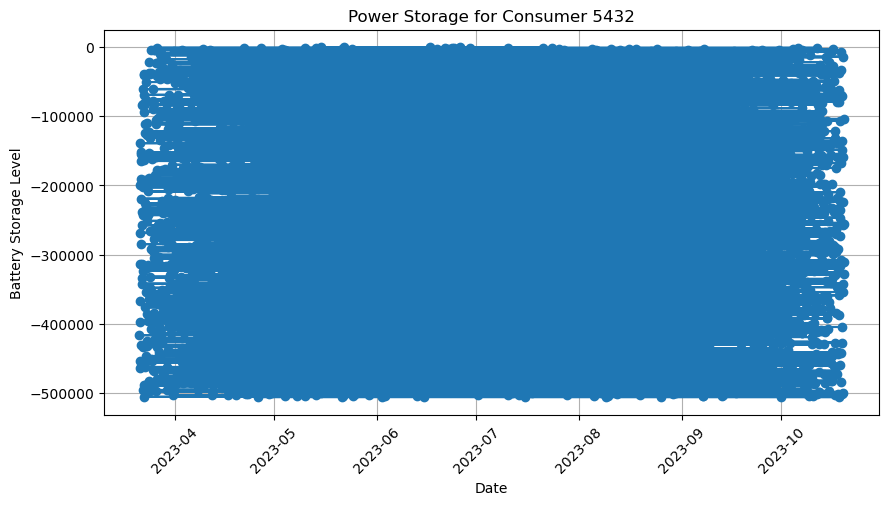

In [17]:
import matplotlib.pyplot as plt

# Plot power levels of a specific consumer
consumer_id = '5432'  # Choose a consumer ID from the dataset

if consumer_id in consumers:
    timestamps, storage_levels = zip(*consumers[consumer_id].history)

    plt.figure(figsize=(10,5))
    plt.plot(timestamps, storage_levels, marker='o', linestyle='-')
    plt.xlabel("Date")
    plt.ylabel("Battery Storage Level")
    plt.title(f"Power Storage for Consumer {consumer_id}")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


In [18]:
MAX_CAPACITY = 500  # kWh (example max capacity)
MIN_CAPACITY = 0  # Cannot go below zero

class Consumer:
    def __init__(self, consumer_id, initial_storage=100):
        self.id = consumer_id
        self.storage = initial_storage  # Battery storage level
        self.history = []

    def update_storage(self, received, sent, timestamp):
        """ Updates storage and prevents overcharge/undercharge """
        self.storage += (received - sent)

        # Apply limits
        self.storage = max(MIN_CAPACITY, min(MAX_CAPACITY, self.storage))

        self.history.append((timestamp, self.storage))

In [ ]:
import simpy

def power_simulation(env, consumer, dataset):
    """ Simulate power flow for a single consumer """
    for _, row in dataset.iterrows():
        if row["ID"] == consumer.id:
            yield env.timeout(1)  # Move simulation time forward
            consumer.update_storage(row["recieved"], row["sent"], row["date"])
            print(f"Time: {env.now}, Consumer {consumer.id} Storage: {consumer.storage}")

# Initialize simulation
env = simpy.Environment()

# Create and run processes
for consumer in consumers.values():
    env.process(power_simulation(env, consumer, df))

env.run()